In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import intel_extension_for_pytorch as ipex
import time
import matplotlib.pyplot as plt


BS_TRAIN = 1
BS_TEST  = 1
EPOCHNUM = 2


In [2]:
class TestDataset(Dataset):
    def __init__(self, train = True):
        super(TestDataset, self).__init__()
        self.train = train

    def __getitem__(self, index):
        if self.train:
            return torch.rand(3, 112, 112), torch.rand(6, 110, 110)
        else:
            return torch.rand(3, 112, 112)

    def __len__(self):
        if self.train:
            return 100
        else:
            return 20

In [3]:
class TestModel(nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()
        self.conv = nn.Conv2d(3, 6, 3)
        self.norm = nn.BatchNorm2d(6)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

In [4]:
def train_test(ipex_enable):
    '''
    The following 3 components are required to perform training.
    1. model: Instantiate model class
    2. optim: Optimization function for update topology parameters during training
    3. crite: Criterion function to minimize loss
    '''
    model = TestModel()
    model = model.to(memory_format=torch.channels_last)
    optim = torch.optim.SGD(model.parameters(), lr=0.01)
    crite = nn.MSELoss(reduction='sum')

    '''
    1. Instantiate the Dataset class defined before
    2. Use torch.utils.data.DataLoader to load data from the Dataset instance
    '''
    train_data  = TestDataset()
    trainLoader = DataLoader(train_data, batch_size=BS_TRAIN)
    test_data   = TestDataset(train=False)
    testLoader  = DataLoader(test_data, batch_size=BS_TEST)

    '''
    Apply Intel Extension for PyTorch optimization against the model object and optimizer object.
    '''
    if(ipex_enable):
        model, optim = ipex.optimize(model, optimizer=optim)

    '''
    Perform training and inference
    Use model.train() to set the model into train mode. Use model.eval() to set the model into inference mode.
    Use for loop with enumerate(instance of DataLoader) to go through the whole dataset for training/inference.
    '''

    train_time_list = []
    test_time_list = []

    for i in range(0, EPOCHNUM - 1):
        '''
        Iterate dataset for training to train the model
        '''

        model.train()

        for batch_index, (data, y_ans) in enumerate(trainLoader):
            data = data.to(memory_format=torch.channels_last)
            optim.zero_grad()
            t1 = time.time()
            y = model(data)
            train_time = time.time() - t1
            loss = crite(y, y_ans)
            loss.backward()
            optim.step()
            train_time_list.append(train_time)

    
        '''
        Iterate dataset for validation to evaluate the model
        '''
        model.eval()


        for batch_index, data in enumerate(testLoader):
            data = data.to(memory_format=torch.channels_last)
            t2 = time.time()
            y = model(data)
            test_time = time.time() - t2
            test_time_list.append(test_time)

    
    return sum(train_time_list) / len(train_time_list), sum(test_time_list) / len(test_time_list)

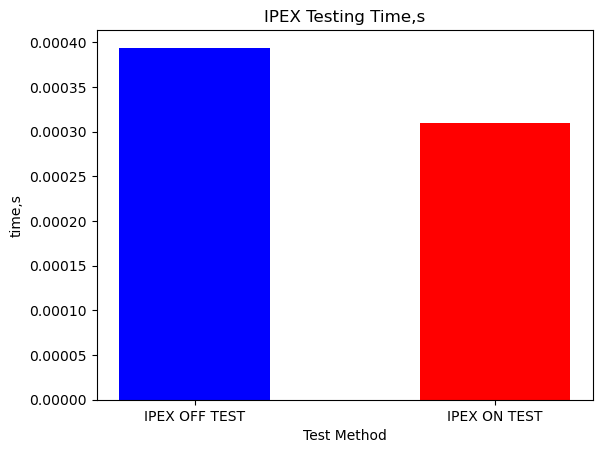

Performance Speedup Testing:  1.2710553653187642
[CODE_SAMPLE_COMPLETED_SUCCESFULLY]


In [5]:
#warm up
ipex_on = False
for i in range(10):
    time_train, time_test = train_test(ipex_on)

#with stock PyTorch
ipex_on = False
time_train, time_test = train_test(ipex_on)

#with IPEX
ipex_on = True
time_train_ipex, time_test_ipex = train_test(ipex_on)

left = [1,2]
# pred_times = [time_train, time_train_ipex]
# tick_label = ['IPEX OFF TRAIN', 'IPEX ON TRAIN']
# plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['blue', 'red'])
# plt.xlabel('Training Method'); plt.ylabel('time,s'); plt.title('IPEX Training Time,s')
# plt.show()

# print("Performance Speedup Training: ",(time_train)/(time_train_ipex))
# plt.clf()

pred_times = [time_test, time_test_ipex]
tick_label = ['IPEX OFF TEST', 'IPEX ON TEST']
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['blue', 'red'])
plt.xlabel('Test Method'); plt.ylabel('time,s'); plt.title('IPEX Testing Time,s')
plt.show()

print("Performance Speedup Testing: ",(time_test)/(time_test_ipex))

print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')